In [1]:
import gym # loading the Gym library
from genrl.agents import QLearning
from genrl.trainers import ClassicalTrainer

_**note:**_ By default, the Frozen Lake environment provided in Gym has probabilistic transitions between states. In other words, even when our agent chooses to move in one direction, the environment can execute a movement in another direction


actions = {
    'Left': 0,
    'Down': 1,
    'Right': 2, 
    'Up': 3
}

# Exercise 1

In [2]:
total_episodes = 1000

env = gym.make("FrozenLake-v0")
env.reset()                    
env.render()
print("\nAction space: ", env.action_space)
print("Observation space: ", env.observation_space)


SFFF
FHFH
FFFH
HFFG

Action space:  Discrete(4)
Observation space:  Discrete(16)


Evaluating at the episode number: 0
Evaluating on 100 episodes, Mean Reward: 0.0 and Std Deviation for the reward: 0.0
Evaluating at the episode number: 10
Evaluating on 100 episodes, Mean Reward: 0.0 and Std Deviation for the reward: 0.0
Evaluating at the episode number: 20
Evaluating on 100 episodes, Mean Reward: 0.0 and Std Deviation for the reward: 0.0
Evaluating at the episode number: 30
Evaluating on 100 episodes, Mean Reward: 0.0 and Std Deviation for the reward: 0.0
Evaluating at the episode number: 40
Evaluating on 100 episodes, Mean Reward: 0.0 and Std Deviation for the reward: 0.0
Evaluating at the episode number: 50
Evaluating on 100 episodes, Mean Reward: 0.0 and Std Deviation for the reward: 0.0
Evaluating at the episode number: 60
Evaluating on 100 episodes, Mean Reward: 0.0 and Std Deviation for the reward: 0.0
Evaluating at the episode number: 70
Evaluating on 100 episodes, Mean Reward: 0.0 and Std Deviation for the reward: 0.0
Evaluating at the episode number: 80
Eval

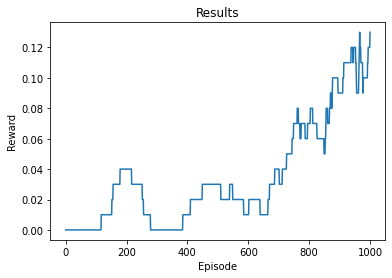

In [3]:
env = gym.make("FrozenLake-v0")
agent = QLearning(env)
trainer = ClassicalTrainer(agent, env, mode="dyna", model="tabular", n_episodes=total_episodes, evaluate_frequency=10)
episode_rewards = trainer.train()
trainer.plot(episode_rewards)


# Exercise 2

In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
env = gym.make('FrozenLake-v0')
total_episodes = 1000
win_pct = []
scores = []

obs = env.reset()
print(env.observation_space)

Discrete(16)


In [6]:
def get_next_action(state):
    # prefer down before right:
    # SFFF
    # FHFH
    # FFFH
    # HFFG
    # { 'Left': 0, 'Down': 1, 'Right': 2, 'Up': 3 }
    policy = {0: 1, 1:2, 2:1, 3:0, 4: 1, 6: 1, 8:2, 9:1, 10:1, 13: 2, 14:2}
    return policy[state]

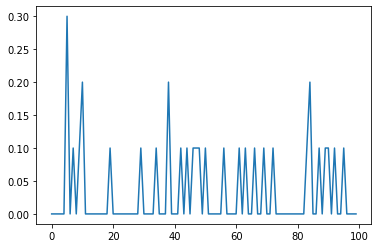

In [7]:
for i in range(total_episodes):
    done = False
    state = env.reset()
    score = 0   
    while not done:
        # some_action = env.action_space.sample() #samples a random action
        next_action = get_next_action(state)
        state, reward, done, info = env.step(next_action) #agent takes action (random_action)
        score += reward
        
    scores.append(score)

    if i % 10 == 0:
        average = np.mean(scores[-10:])
        win_pct.append(average)

plt.plot(win_pct)
plt.show()

# Exercise 3

- initialize Q for all states and actions
- set alpha to 0.001 gamma to 0.9 epsilon_max to 1 and espilon_min to 0.01

In [8]:
import random
env = gym.make('FrozenLake-v0')
total_episodes = 500000

env.reset()

Q = np.zeros((env.observation_space.n, env.action_space.n))
alpha = 0.001
gamma = 0.9
epsilon_max = 1.0
epsilon_min = 0.01

In [9]:
class Agent:
    def __init__(self, Q, alpha, gamma, n_epsiodes, n_actions, epsilon_max=1.0, epsilon_min=0, epsilon_dec_mod=1.0):
        self.Q = Q
        self.alpha = alpha # learning rate
        self.gamma = gamma # discount factor
        self.n_actions = n_actions
        self.epsilon_max = epsilon_max
        self.epsilon_min = epsilon_min
        self.epsilon_dec = epsilon_dec_mod * (1-(1/n_epsiodes)) ** 2
        self.epsilon = epsilon_max
        self.state = None

    def __decrement_epsilon(self):
        self.epsilon = self.epsilon * self.epsilon_dec if self.epsilon > self.epsilon_min \
                        else self.epsilon_min
    
    def select_action(self,): # apply epsilon greedy 
        if random.uniform(0,1) < self.epsilon: # explore - random action
            action = np.random.choice([i for i in range(self.n_actions)])
        else: # exploit - a_max in Q at state
            action = np.argmax([self.Q[(state, a)] for a in range(self.n_actions)])
        return action

    def update(self, state, action, reward):
        self.Q[self.state, action] += self.alpha * (reward + self.gamma * \
            np.max(self.Q[state]) - self.Q[self.state, action])

        self.state = state
        self.__decrement_epsilon()


- repeat for n_episodes
- - initialize state s
- - for each step of episode
- - - choose an action based on state s with an epsilon_greedy strategy in Q 
- - - take the action, get new_state and reward.
- - - update with the new reward, pluggin in to the equation below in Q:
Q(s,a) = Q(s,a) + alpha * (r + gamme * max(Q(s', a_max))-Q(s,a))
- - - update state

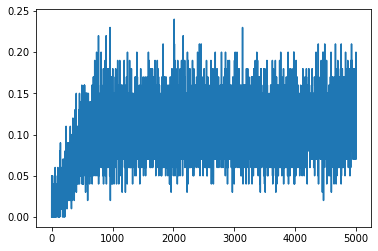

In [10]:
agent = Agent(Q, alpha, gamma, total_episodes, env.action_space.n, epsilon_max, epsilon_min)
win_pct = []
scores = []

for i in range(total_episodes):
    state = env.reset()
    score = 0
    done = False
    while not done:
        next_action = agent.select_action()
        state, reward, done, info = env.step(next_action)
        agent.update(state, next_action, reward)
        score += reward
        
    scores.append(score)

    if i % 100 == 0:
        average = np.mean(scores[-100:])
        win_pct.append(average)

plt.plot(win_pct)
plt.show()